In [1052]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

CARGAR ARCHIVO

In [1053]:
df = pd.read_csv("../files/input/solicitudes_de_credito.csv", sep=';', encoding='utf-8')

# Ver las primeras 5 filas
print(df.head())

   Unnamed: 0       sexo tipo_de_emprendimiento          idea_negocio  \
0           0  masculino               comercio           fabrica de    
1           1   femenino               servicio  recreativo-educativo   
2           2   femenino               comercio                tienda   
3           3  Masculino               comercio            variedades   
4           4   femenino               comercio           fabrica de    

                   barrio  estrato  comuna_ciudadano fecha_de_beneficio  \
0                   prado        3              10.0         13/07/2018   
1          barrio caicedo        1               9.0         30/10/2017   
2                aranjuez        2               4.0          3/08/2017   
3  cabecera san cristobal        3              60.0         20/11/2017   
4                 robledo        2               7.0         23/02/2017   

  monto_del_credito     línea_credito  
0           5000000  microempresarial  
1           6000000  microempr

FUNCIONES

In [1054]:
def convertir_columna_a_int(df, nombre_columna):
    """
    Convierte una columna de un DataFrame a tipo entero (int).
    """
    # Convertir a string
    df[nombre_columna] = df[nombre_columna].astype(str)
    # Eliminar caracteres no deseados
    df[nombre_columna] = df[nombre_columna].str.replace(r'[$,.\s]', '', regex=True)
    # Convertir a int
    df[nombre_columna] = df[nombre_columna].astype(int)
    return df

In [1055]:
def convertir_columna_a_float(df, nombre_columna):
    """
    Convierte una columna de un DataFrame a float limpiando primero los caracteres
    '$', ',', y espacios, manteniendo el punto decimal.
    """
    # Convertir a string
    df[nombre_columna] = df[nombre_columna].astype(str)
    # Eliminar caracteres $ , y espacios
    df[nombre_columna] = df[nombre_columna].str.replace(r'[$,\s]', '', regex=True)
    # Convertir a float
    df[nombre_columna] = df[nombre_columna].astype(float)
    return df


In [1056]:
def convertir_columna_categorica(df, nombre_columna):
    # Convertir a string
    df[nombre_columna] = df[nombre_columna].astype(str)

    # Convertir a categoría
    df[nombre_columna] = df[nombre_columna].astype('category')

    return df


In [1057]:
def normalizar_a_dia_mes_ano(fecha_str):
    """
    Normaliza y convierte fechas a formato dd/mm/yyyy como string,
    agregando ceros y reordenando si es necesario.
    """
    if pd.isna(fecha_str):
        return fecha_str

    sep = '/' if '/' in fecha_str else '-'
    partes = fecha_str.split(sep)
    
    if len(partes) == 3:
        if len(partes[0]) == 4:  # yyyy/mm/dd
            # Reordenar a dd/mm/yyyy
            year, month, day = partes
            day = day.zfill(2)
            month = month.zfill(2)
            return f"{day}/{month}/{year}"
        else:  # dd/mm/yyyy o mm/dd/yyyy (asumimos dd/mm/yyyy)
            day, month, year = partes
            day = day.zfill(2)
            month = month.zfill(2)
            return f"{day}/{month}/{year}"
    else:
        return fecha_str


In [1058]:
def convertir_columna_a_fecha(df, nombre_columna):
    """
    Convierte una columna de un DataFrame a tipo fecha (datetime), 
    manejando formatos mixtos como 'd/m/Y' y 'Y/m/d'.
    """   
    df[nombre_columna] = df[nombre_columna].astype(str).str.strip()
    df[nombre_columna] = df[nombre_columna].apply(normalizar_a_dia_mes_ano)
    df[nombre_columna] = pd.to_datetime(df[nombre_columna], dayfirst=True, errors='coerce')
    return df



In [1059]:
def convertir_strings_a_minusculas(df):
    """
    Convierte todas las columnas de tipo string en un DataFrame a minúsculas.
    
    Parámetros:
    - df: pandas.DataFrame
    
    Retorna:
    - DataFrame con strings en minúsculas
    """
    for col in df.select_dtypes(include=['object', 'string']).columns:
        df[col] = df[col].str.lower()
    return df


In [1060]:
def valores_unicos_por_columna_objeto_con_cuenta(df):
    """
    Para cada columna de tipo object en el DataFrame,
    devuelve un diccionario con la columna y sus valores únicos en forma de lista,
    y además imprime el número de valores únicos.
    """
    resultado = {}
    for col in df.select_dtypes(include=['object']).columns:
        únicos = df[col].dropna().unique().tolist()
        resultado[col] = únicos
    return resultado


In [1061]:
def limpiar_espacios_en_strings(df):
    """
    En columnas string, reemplaza '_', '-', '.', ',' por espacio,
    luego reduce múltiples espacios a uno solo y elimina espacios al inicio y final.
    """
    for col in df.select_dtypes(include=['object', 'string']).columns:
        # Reemplazar caracteres por espacio
        df[col] = df[col].str.replace(r'[_\-.,]', ' ', regex=True)
        # Reducir múltiples espacios a uno
        df[col] = df[col].str.replace(r'\s+', ' ', regex=True)
        # Quitar espacios al inicio y al final
        df[col] = df[col].str.strip()
    return df


In [1062]:
def eliminar_filas_con_nulos(df):
    """
    Elimina todas las filas del DataFrame que contengan al menos un valor nulo.
    Retorna el DataFrame limpio.
    """
    df_limpio = df.dropna()
    return df_limpio


In [1063]:
def imprimir_valores_columnas_categoricas(df):
    """
    Imprime los valores únicos de todas las columnas categóricas en el DataFrame.
    
    Parámetro:
    - df: pandas.DataFrame
    """
    columnas_categoricas = df.select_dtypes(include=['category']).columns
    for col in columnas_categoricas:
        print(f"\nColumna: {col}")
        print(f"Valores únicos ({df[col].nunique()}): {df[col].cat.categories.tolist()}")


FUNCIONES PERSONALIZADAS

In [1064]:
def limpiar_barrio(texto):
    if not isinstance(texto, str):
        return texto  # Si es NaN o no str, devolver tal cual
    
    # Quitar prefijos 'barrio', 'vereda', 'vrda' y variaciones
    texto = re.sub(r'\b(barrio|vereda|vrda|villa|suburbano|sector|unidad|urbanización|urbanizacion|urbanizaci[oó]n)\b', '', texto)
    
    # Quitar numeraciones tipo ' no 1', ' no 2', ' no', etc.
    texto = re.sub(r'\bno\s*\d*\b', '', texto)
    
    # Corregir caracteres extraños (ejemplo 'bel¿n' → 'belen')
    texto = texto.replace('¿', '').replace('í', 'i').replace('ó', 'o').replace('á', 'a').replace('é', 'e').replace('ú', 'u')
    
    # Quitar caracteres especiales que no sean letras ni números ni espacios
    texto = re.sub(r'[^a-z0-9\s]', '', texto)
    
    # Reemplazar múltiples espacios por uno solo
    texto = re.sub(r'\s+', ' ', texto)
    
    # Quitar espacios al inicio y final
    texto = texto.strip()
    
    return texto

In [1065]:
def normalizar_idea_negocio(texto):
    if not isinstance(texto, str):
        return texto
    texto = texto.lower().strip()
        
     # Quitar artículos/preposiciones comunes
    texto = re.sub(r'\b(de|la|el|y|en|para|con|del)\b', '', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
        
    # Agrupar categorías genéricas
    if texto.startswith('fabrica'):
        return 'fabrica'
    if texto.startswith('venta'):
        return 'venta'
    if texto.startswith('tienda'):
        return 'tienda'
    if texto.startswith('taller'):
        return 'taller'
    if texto.startswith('deposito'):
        return 'deposito'
    if texto in ['servicios', 'servicio']:
        return 'servicios'

    return texto


In [1066]:
def detectar_outliers_iqr(df, columna):
    """
    Detecta y muestra outliers usando el método del IQR.
    También grafica los valores con un boxplot.
    """
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 10.0 * IQR
    limite_superior = Q3 + 10.0 * IQR

    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
    
    print(f"Outliers detectados en '{columna}': {len(outliers)}")
    print(f"Rango permitido: {limite_inferior:.2f} a {limite_superior:.2f}")
    
    # Boxplot
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[columna])
    plt.title(f'Boxplot de {columna}')
    plt.show()

    return outliers


In [1067]:
def eliminar_n_mayores(df, nombre_columna, n):
    """
    Elimina las filas que contienen los n valores más grandes de una columna.
    
    Parámetros:
    - df: DataFrame original
    - nombre_columna: str, nombre de la columna a analizar
    - n: int, cantidad de valores más grandes a eliminar

    Retorna:
    - DataFrame sin las filas con los n valores más altos
    """
    # Obtener los índices de los n valores más grandes
    indices_a_eliminar = df[nombre_columna].nlargest(n).index
    # Eliminar esas filas
    df_filtrado = df.drop(index=indices_a_eliminar)
    return df_filtrado


ELIMINAR VALORES NULOS INECESARIOS

In [1068]:
# Conteo de valores nulos por columna
print(df.isnull().sum())

# Porcentaje de valores nulos
print((df.isnull().mean() * 100).round(2))

df = eliminar_filas_con_nulos(df)

Unnamed: 0                  0
sexo                        0
tipo_de_emprendimiento    102
idea_negocio                0
barrio                    102
estrato                     0
comuna_ciudadano            0
fecha_de_beneficio          0
monto_del_credito           0
línea_credito               0
dtype: int64
Unnamed: 0                0.00
sexo                      0.00
tipo_de_emprendimiento    0.93
idea_negocio              0.00
barrio                    0.93
estrato                   0.00
comuna_ciudadano          0.00
fecha_de_beneficio        0.00
monto_del_credito         0.00
línea_credito             0.00
dtype: float64


CONVERTIR TIPOS DE COLUMNAS 

In [1069]:
df= convertir_columna_a_int(df, "monto_del_credito")
df= convertir_columna_a_int(df, "comuna_ciudadano")
df= convertir_columna_a_fecha(df, "fecha_de_beneficio")
df= convertir_columna_categorica(df, "estrato")
df= convertir_columna_categorica(df, "comuna_ciudadano")

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 10716 entries, 0 to 10919
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Unnamed: 0              10716 non-null  int64         
 1   sexo                    10716 non-null  object        
 2   tipo_de_emprendimiento  10716 non-null  object        
 3   idea_negocio            10716 non-null  object        
 4   barrio                  10716 non-null  object        
 5   estrato                 10716 non-null  category      
 6   comuna_ciudadano        10716 non-null  category      
 7   fecha_de_beneficio      10716 non-null  datetime64[ns]
 8   monto_del_credito       10716 non-null  int64         
 9   línea_credito           10716 non-null  object        
dtypes: category(2), datetime64[ns](1), int64(2), object(5)
memory usage: 775.3+ KB
None


TRANSFORMAR COLUMNAS CATEGORICAS

In [1070]:
df= convertir_strings_a_minusculas(df)
df= limpiar_espacios_en_strings(df)
df= convertir_columna_categorica(df, "línea_credito")

df['barrio'] = df['barrio'].apply(limpiar_barrio)
df['idea_negocio'] = df['idea_negocio'].apply(normalizar_idea_negocio)

unicos = valores_unicos_por_columna_objeto(df)
for columna, valores in unicos.items():
    print(f"Columna '{columna}': {len(valores)},{valores}")

Columna 'sexo': 2,['masculino', 'femenino']
Columna 'tipo_de_emprendimiento': 4,['comercio', 'servicio', 'industria', 'agropecuaria']
Columna 'idea_negocio': 56,['fabrica', 'recreativo educativo', 'tienda', 'variedades', 'sembrados', 'comidas rapidas', 'miscelanea', 'cafe e internet', 'venta', 'productos belleza', 'almacen ropa', 'barberia', 'peluqueria', 'jardineria', 'panaderia', 'mantenimiento', 'bares', 'criadero animales', 'restaurante', 'organización', 'carpinteria', 'drogueria', 'productos mar', 'ebanistaria', 'papeleria', 'carniceria', 'cafeteria', 'legumbreria', 'ferreteria', 'distribuidora', 'taller', 'lavanderia', 'servicios', 'billares', 'licorera', 'marroquineria', 'granero', 'deposito', 'reciclaje', 'cerrajeria', 'charcuteria', 'fotografia', 'hoteles moteles', 'viveros', 'publicidad', 'joyeria', 'lenceria', 'lavadero', 'montallantas', 'marqueteria', 'gimnasio', 'fumigacion', 'floristeria', 'pañalera', 'mensajeria', 'alquiler peliculas']
Columna 'barrio': 209,['prado', 'ca

In [1071]:
df= convertir_columna_categorica(df, "sexo")
df= convertir_columna_categorica(df, "tipo_de_emprendimiento")


print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 10716 entries, 0 to 10919
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Unnamed: 0              10716 non-null  int64         
 1   sexo                    10716 non-null  category      
 2   tipo_de_emprendimiento  10716 non-null  category      
 3   idea_negocio            10716 non-null  object        
 4   barrio                  10716 non-null  object        
 5   estrato                 10716 non-null  category      
 6   comuna_ciudadano        10716 non-null  category      
 7   fecha_de_beneficio      10716 non-null  datetime64[ns]
 8   monto_del_credito       10716 non-null  int64         
 9   línea_credito           10716 non-null  category      
dtypes: category(5), datetime64[ns](1), int64(2), object(2)
memory usage: 556.2+ KB
None


In [1072]:
imprimir_valores_columnas_categoricas(df)


Columna: sexo
Valores únicos (2): ['femenino', 'masculino']

Columna: tipo_de_emprendimiento
Valores únicos (4): ['agropecuaria', 'comercio', 'industria', 'servicio']

Columna: estrato
Valores únicos (4): ['0', '1', '2', '3']

Columna: comuna_ciudadano
Valores únicos (21): ['10', '100', '110', '120', '130', '140', '150', '160', '20', '30', '40', '50', '500', '60', '600', '70', '700', '80', '800', '90', '900']

Columna: línea_credito
Valores únicos (9): ['agropecuaria', 'ayacucho formal', 'credioportuno', 'empresarial ed', 'fomento agropecuario', 'juridica y cap semilla', 'microempresarial', 'soli diaria', 'solidaria']


In [1073]:
print(df.sexo.value_counts().to_list())
#[6938, 3778]=10716
#[6617, 3589]=10206
#510

[6938, 3778]


ENCONTRAR OUTLINERS

In [1074]:
negativos = df[df['monto_del_credito'] < 0]['monto_del_credito']
print(negativos)

Series([], Name: monto_del_credito, dtype: int64)


In [ ]:
#df= eliminar_n_mayores(df, 'monto_del_credito', 510)

Outliers detectados en 'monto_del_credito': 77
Rango permitido: -29700000.00 a 41070000.00


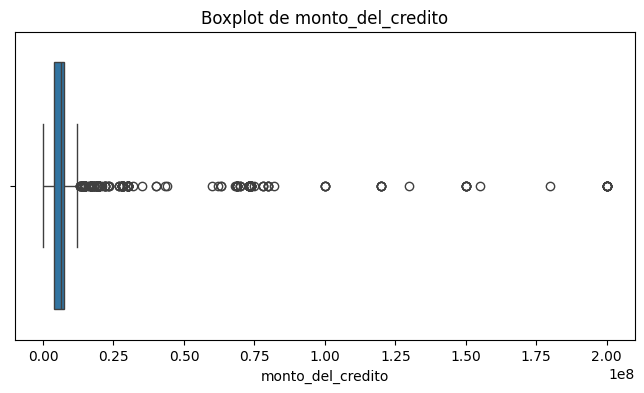

In [1076]:
outliers_credito = detectar_outliers_iqr(df, 'monto_del_credito')
#df = df[~df.index.isin(outliers_credito.index)]


In [1077]:
print(df.sexo.value_counts().to_list())

[6615, 3591]
